In [1]:
import os
import sys
import numpy as np
import argparse
import h5py
import math
import random
import time
import logging
import matplotlib.pyplot as plt
import sklearn
import csv

import torch
import torchaudio
#torch.backends.cudnn.benchmark=True
#torch.manual_seed(0)
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torch.utils.data
 
sys.path.append("utils")
from utilities import get_filename
sys.path.append("pytorch/")
from models import *
import config


In [2]:

class Transfer_Cnn14(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn14, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn14(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(2048, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']

        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [3]:
class Transfer_Cnn10(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn10, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn10(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(512, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']
        #print(embedding.shape)
        #print(self.fc_transfer(embedding).shape)
        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [4]:
class Transfer_Cnn6(nn.Module):
    def __init__(self, sample_rate, window_size, hop_size, mel_bins, fmin, 
        fmax, classes_num, freeze_base):
        """Classifier for a new task using pretrained Cnn14 as a sub module.
        """
        super(Transfer_Cnn6, self).__init__()
        audioset_classes_num = 527
        
        self.base = Cnn6(sample_rate, window_size, hop_size, mel_bins, fmin, 
            fmax, audioset_classes_num)

        # Transfer to another task layer
        self.fc_transfer = nn.Linear(512, classes_num, bias=True)

        if freeze_base:
            # Freeze AudioSet pretrained layers
            for param in self.base.parameters():
                param.requires_grad = False

        self.init_weights()

    def init_weights(self):
        init_layer(self.fc_transfer)

    def load_from_pretrain(self, pretrained_checkpoint_path):
        checkpoint = torch.load(pretrained_checkpoint_path)
        self.base.load_state_dict(checkpoint['model'])

    def forward(self, input, mixup_lambda=None):
        """Input: (batch_size, data_length)
        """
        output_dict = self.base(input, mixup_lambda)
        embedding = output_dict['embedding']
        #print(embedding.shape)
        #print(self.fc_transfer(embedding).shape)
        clipwise_output =  torch.log_softmax(self.fc_transfer(embedding), dim=-1)
        output_dict['clipwise_output'] = clipwise_output
 
        return output_dict

In [5]:
data_emotion_target_dictionary = {}

#emotion recognition
folder = '../../data_train/train/'

data_paths_train = []

for file in os.listdir(folder):
    file_path = folder + file
    #to be consistent with rest of the code - we do not want to split these into 4 seconds audios
    data_path = file_path
    data_paths_train.append(data_path)
    v = file.replace('.wav','').split('_')
    emotion_label = v[len(v)-1]
    data_emotion_target_dictionary[file_path] = emotion_label
    #print(emotion_label)

random.shuffle(data_paths_train)
    
number_files = len(data_paths_train)
#using part of training set as test set
#validation_cut = int(math.floor(0.8*number_files))
#test_cut = int(math.floor(0.9*number_files))
#data_paths_valid = data_paths_train[validation_cut:test_cut]
#data_paths_test = data_paths_train[test_cut:]
#data_paths_train = data_paths_train[:validation_cut]   


#using official test set
#validation_cut = int(math.floor(0.9*number_files))
#data_paths_valid = data_paths_train[validation_cut:]
#data_paths_train = data_paths_train[:validation_cut]

folder = '../../data_train/validation/'

data_paths_valid = []

for file in os.listdir(folder):
    file_path = folder+file
    data_path = file_path
    data_paths_valid.append(data_path)
    v = file.replace('.wav','').split('_')
    emotion_label = v[len(v)-1]
    data_emotion_target_dictionary[file_path] = emotion_label

random.shuffle(data_paths_valid)

In [6]:
#using official test set

folder = '../../data_train/test_ser_labeled/'

data_paths_test = []

for file in os.listdir(folder):
    file_path = folder + file
    #to be consistent with rest of the code - we do not want to split these into 4 seconds audios
    data_path = file_path
    data_paths_test.append(data_path)
    v = file.replace('.wav','').split('_')
    emotion_label = v[len(v)-1]
    data_emotion_target_dictionary[file_path] = emotion_label

In [7]:
#using official test set

folder = '../../data_train/test_ser/'

data_paths_no_label_test = []

for file in os.listdir(folder):
    file_path = folder + file
    #to be consistent with rest of the code - we do not want to split these into 4 seconds audios
    data_path = file_path
    data_paths_no_label_test.append(data_path)

In [8]:
#build function to process data in batches
def process_batches(data_paths, data_emotion_target_dictionary, number_coeffs, min_frequency, max_frequency, batch_size, pretrain, path_index):
    
    #parameters below maybe should be defined elsewhere
    #set audio length in seconds - this is max length of audios
    audio_length = 16
    device = 'cuda'
    new_sample_rate = 32000
    
    
    
    ################################
    
    data_batch = []
    
    #in case we are doing supervised training we also need to store whether the file comes from healthy/unhealthy - is always computed but only used for supervised training
    data_ri_target_list = []
    data_gen_target_list = []
    data_age_target_list = []
    data_emotion_target_list = []
    
    while len(data_batch) < batch_size and path_index < len(data_paths):
        data_path_with_index = data_paths[path_index]
        data_path = data_path_with_index
        sample_rate = torchaudio.info(data_path).sample_rate
        
        data_elem, sample_rate = torchaudio.load(data_path)
        #downsampling to fit gpu memory
        data_elem = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(data_elem)
        sample_rate = new_sample_rate
        data_elem = data_elem[0]
        
        data_batch.append(data_elem)
        
        #for supervised training we store data about the file
        if pretrain != 'pretrain':
            if pretrain == 'emotion':
                if data_emotion_target_dictionary[data_path] == 'neutral':
                    data_emotion_target_list.append(0)
                elif data_emotion_target_dictionary[data_path] == 'non-neutral-male':
                    data_emotion_target_list.append(1)
                elif data_emotion_target_dictionary[data_path] == 'non-neutral-female':
                    data_emotion_target_list.append(2)
                else:#this should not happen
                    data_emotion_target_list.append(3)
        
        path_index +=1
        
    #convert list to torch tensor (pads different audio lengths to same size)
    data_batch = nn.utils.rnn.pad_sequence(data_batch, batch_first=True)
    
    data_batch = data_batch.to(device)
    
    #for supervised training
    data_emotion_target_list = torch.LongTensor(data_emotion_target_list)
    data_emotion_target_list = data_emotion_target_list.to(device)
    ###########################
    
    #data_batch = torchaudio.transforms.MelSpectrogram(sample_rate, n_mels=number_coeffs, f_min=min_frequency, f_max=max_frequency).to(device)(data_batch)
    #print(data_batch.shape)

    
    #permute so we have batch_size, time, n_coeffs
    #data_batch = data_batch.permute(0,2,1)

    return data_batch, data_emotion_target_list, path_index

In [9]:
#function to train model
def run_epoch(model, loss_compute, data_paths, avg_loss=0, pretrain='pretrain', training=True, batch_size=16, extract_coeffs='both', min_frequency = 0.0, max_frequency=None, number_coeffs=128, mask_proportion=0., mask_consecutive_frames=7, mask_frequency_proportion=0., random_noise_proportion=0.0):
    "Standard Training and Logging Function"
    start = time.time()
    total_tokens = 0
    total_loss = 0
    tokens = 0
    train_acc_avg = 0
    f1_score_avg = 0
    
    number_elements = len(data_paths)
    #number_steps = int(math.ceil(number_elements/batch_size))
    
    outputs=[]
    targets=[]
    
    #path index is the index of the audio file in the filenames list
    path_index = 0
    #step index stores the amount of steps taken by the algorithm so far
    step_index = 0
    while path_index < number_elements:
        step_index +=1
        #load the data and mask it
        data_batch, data_emotion_target_list, path_index = process_batches(data_paths, data_emotion_target_dictionary, number_coeffs, min_frequency, max_frequency, batch_size, pretrain, path_index)
        b_size = data_batch.shape[0]
        #pass data through transformer
        #print(data_batch.shape)
        output_dict = model.forward(data_batch)
        #compute loss
        #print('out', out.shape)
        #print('data_batch', data_batch.shape)
        if pretrain == 'pretrain':
            #print('data_batch')
            loss, train_acc = loss_compute(output_dict, data_batch, training)
        elif pretrain == 'emotion':
            loss, train_acc, f1_score, output, target = loss_compute(output_dict, data_emotion_target_list, training)
        
        outputs.append(output)
        targets.append(target)

        total_loss += loss
        avg_loss = avg_loss*0.99 + loss*0.01
        train_acc_avg = (train_acc_avg*(step_index-1)+train_acc)/(step_index)
        f1_score_avg = (f1_score_avg*(step_index-1)+f1_score)/(step_index)
        total_tokens += b_size
        tokens += b_size
        
        #if path_index > 10:
        #    break
        
        if step_index % 5 == 1:
            elapsed = time.time() - start
            print("Epoch Step: %d Loss: %f Tokens per Sec: %f Train_acc: %f F1_score: %f" %
                    (step_index, avg_loss, tokens / elapsed, train_acc_avg, f1_score_avg))
            start = time.time()
            tokens = 0

    outputs = np.concatenate(outputs)
    targets = np.concatenate(targets)
    true_f1_score = sklearn.metrics.f1_score(outputs, targets, labels=[0,1,2], average='macro')
    print('Final F1_score=', true_f1_score)
    
    return total_loss / (total_tokens), avg_loss, train_acc_avg, f1_score_avg, true_f1_score

In [10]:
#function to write model test outputs to a csv file
def write_to_csv(model, csv_filepath, data_paths):
    header = ['file_path', 'label']
    with open(csv_filepath, 'w') as f:
        writer = csv.writer(f)
        #write header
        writer.writerow(header)

        new_sample_rate = 32000
        
        for index in range(len(data_paths)):
            data_batch = []
            data_path = data_paths[index]
            data_elem, sample_rate = torchaudio.load(data_path)
            #downsampling to fit gpu memory
            data_elem = torchaudio.transforms.Resample(sample_rate, new_sample_rate)(data_elem)
            sample_rate = new_sample_rate
            data_elem = data_elem[0]
            data_batch.append(data_elem)
            #convert to tensor with batch size 1
            data_batch = nn.utils.rnn.pad_sequence(data_batch, batch_first=True)
            data_batch = data_batch.to(device)
            #run model
            output_dict = model.forward(data_batch)
            _, predicted = torch.max(output_dict['clipwise_output'], 1)
            preds = predicted.detach().cpu().clone()
            #print(output_dict['clipwise_output'])
            if preds[0] == 0:
                pred_string = 'neutral'
            elif preds[0] == 1:
                pred_string = 'non-neutral-male'
            elif preds[0] == 2:
                pred_string = 'non-neutral-female'
            #we use data_path[26:] to remove the folder from the path
            data_row = [data_path[26:], pred_string]
            writer.writerow(data_row)
            
    return True
            

In [11]:
class NoamOpt:
    "Optim wrapper that implements rate."
    def __init__(self, model_size, factor, warmup, optimizer):
        self.optimizer = optimizer
        self._step = 0
        self.warmup = warmup
        self.factor = factor
        self.model_size = model_size
        self._rate = 0
        
    def step(self):
        "Update parameters and rate"
        self._step += 1
        rate = self.rate()
        for p in self.optimizer.param_groups:
            p['lr'] = rate
        self._rate = rate
        self.optimizer.step()
        
    def rate(self, step = None):
        "Implement `lrate` above"
        if step is None:
            step = self._step
        #return self.factor * \ (self.model_size ** (-0.5) * min(step ** (-0.5), step * self.warmup ** (-1.5)))
        return 0.0001
        
def get_std_opt(model):
    return NoamOpt(model.src_embed[0].d_model, 2, 4000,
            torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

In [12]:
class LossCompute:
    "A simple loss compute and train function."
    def __init__(self, model, opt=None, pretrain='pretrain'):
        self.model = model
        self.opt = opt
        self.pretrain = pretrain
        
    def __call__(self, output_dict, y, training):
        train_acc = 0
        f1_score=0
        if self.pretrain == 'pretrain':
            L1_loss = nn.L1Loss()
            loss = L1_loss(output_dict['clipwise_output'], y)
        else:#emotion
            cross_entropy_loss = nn.CrossEntropyLoss()
            loss = cross_entropy_loss(output_dict['clipwise_output'], y)
            _, predicted = torch.max(output_dict['clipwise_output'], 1)
            train_acc = torch.sum(predicted==y)/y.shape[0]
            preds = predicted.detach().cpu().clone()
            y_true = y.detach().cpu().clone()
            f1_score = sklearn.metrics.f1_score(y_true, preds, labels=[0,1,2], average='macro')
            
        if training == True:
            loss.backward()
            if self.opt is not None:
                self.opt.step()
                self.opt.optimizer.zero_grad()
        return loss.data.item(), train_acc, f1_score, preds, y_true

In [13]:
args = {}
args['sample_rate']= 32000
args['window_size']= 1024
args['hop_size']=320
args['mel_bins']=64
args['fmin']=0
args['fmax']=32000
args['model_type']="Transfer_Cnn10"
args['pretrained_checkpoint_path']="Cnn10_mAP=0.380.pth"
args['freeze_base']=False
args['cuda']=True

In [14]:

# Arguments & parameters
sample_rate = args['sample_rate']
window_size = args['window_size']
hop_size = args['hop_size']
mel_bins = args['mel_bins']
fmin = args['fmin']
fmax = args['fmax']
model_type = args['model_type']
pretrained_checkpoint_path = args['pretrained_checkpoint_path']
freeze_base = args['freeze_base']
device = 'cuda' if (args['cuda'] and torch.cuda.is_available()) else 'cpu'
classes_num = 3#config.classes_num
pretrain = True if pretrained_checkpoint_path else False

# Model
Model = eval(model_type)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num, freeze_base)


# Load pretrained model
if pretrain:
    logging.info('Load pretrained model from {}'.format(pretrained_checkpoint_path))
    model.load_from_pretrain(pretrained_checkpoint_path)


if 'cuda' in device:
    model.to(device)

print('Load pretrained model successfully!')


/home/marcelomatheusgauy/.local/lib/python3.6/site-packages/librosa/filters.py:239: UserWarning: Empty filters detected in mel frequency basis. Some channels will produce empty responses. Try increasing your sampling rate (and fmax) or reducing n_mels.
  "Empty filters detected in mel frequency basis. "


Load pretrained model successfully!


In [11]:
pretrain = 'emotion'
d_model = 512
model_opt = NoamOpt(d_model, 1, 400,
        torch.optim.Adam(model.parameters(), lr=0, betas=(0.9, 0.98), eps=1e-9))

avg_loss=0
best_val_acc = 0
best_val_f1_score = 0
model_path = 'model_test_mel.ckpt'
min_frequency = 0.0
max_frequency = None

for epoch in range(100):
    model.train()
    loss, avg_loss, _, _, _ = run_epoch(model, 
                  LossCompute(model, model_opt, pretrain),
                  data_paths_train, pretrain=pretrain, training=True, avg_loss=avg_loss,
                  min_frequency=min_frequency, max_frequency=max_frequency, number_coeffs=64)
    model.eval()
    with torch.no_grad():
        loss, _, val_acc, val_f1_score, true_val_f1_score = run_epoch(model, 
                    LossCompute(model, None, pretrain=pretrain),
                    data_paths_valid, pretrain=pretrain, training=False,
                    min_frequency=min_frequency, max_frequency=max_frequency, number_coeffs=64)
        print(val_acc)
        print(val_f1_score)
    #if best_val_acc < val_acc:
        #best_val_acc = val_acc
    if best_val_f1_score < true_val_f1_score:
        best_val_f1_score = true_val_f1_score
        print('Saving model')
        torch.save({
            'model_state_dict': model.state_dict()
            }, model_path)
        #torch.save(model, model_path)


/home/marcelomatheusgauy/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)
/home/marcelomatheusgauy/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Epoch Step: 1 Loss: 0.006892 Tokens per Sec: 99.096384 Train_acc: 0.812500 F1_score: 0.453333
Epoch Step: 6 Loss: 0.058821 Tokens per Sec: 66.281721 Train_acc: 0.656250 F1_score: 0.307591
Epoch Step: 11 Loss: 0.096630 Tokens per Sec: 63.942837 Train_acc: 0.693182 F1_score: 0.311762
Epoch Step: 16 Loss: 0.132759 Tokens per Sec: 78.682474 Train_acc: 0.699219 F1_score: 0.301146
Epoch Step: 21 Loss: 0.173489 Tokens per Sec: 60.266084 Train_acc: 0.684524 F1_score: 0.291706
Epoch Step: 26 Loss: 0.197398 Tokens per Sec: 63.740413 Train_acc: 0.699519 F1_score: 0.294070
Epoch Step: 31 Loss: 0.225006 Tokens per Sec: 66.720935 Train_acc: 0.705645 F1_score: 0.292500
Final F1_score= 0.3093077995823991
Epoch Step: 1 Loss: 0.008771 Tokens per Sec: 187.946318 Train_acc: 0.687500 F1_score: 0.271605
Final F1_score= 0.2916666666666667
tensor(0.7792, device='cuda:0')
0.291423402055586
Saving model
Epoch Step: 1 Loss: 0.232676 Tokens per Sec: 103.913288 Train_acc: 0.750000 F1_score: 0.296296
Epoch Step: 6 

Epoch Step: 16 Loss: 0.676747 Tokens per Sec: 77.315143 Train_acc: 0.781250 F1_score: 0.298701
Epoch Step: 21 Loss: 0.684477 Tokens per Sec: 70.864019 Train_acc: 0.758929 F1_score: 0.298810
Epoch Step: 26 Loss: 0.682517 Tokens per Sec: 72.525739 Train_acc: 0.766827 F1_score: 0.298006
Epoch Step: 31 Loss: 0.677355 Tokens per Sec: 72.870169 Train_acc: 0.774194 F1_score: 0.303632
Final F1_score= 0.3254706889174155
Epoch Step: 1 Loss: 0.008577 Tokens per Sec: 180.784095 Train_acc: 0.687500 F1_score: 0.271605
Final F1_score= 0.2916666666666667
tensor(0.7792, device='cuda:0')
0.291423402055586
Epoch Step: 1 Loss: 0.672234 Tokens per Sec: 118.565431 Train_acc: 0.750000 F1_score: 0.285714
Epoch Step: 6 Loss: 0.685215 Tokens per Sec: 75.609130 Train_acc: 0.697917 F1_score: 0.271584
Epoch Step: 11 Loss: 0.684770 Tokens per Sec: 73.183648 Train_acc: 0.744318 F1_score: 0.302332
Epoch Step: 16 Loss: 0.676268 Tokens per Sec: 78.572607 Train_acc: 0.777344 F1_score: 0.303240
Epoch Step: 21 Loss: 0.680

Epoch Step: 31 Loss: 0.648982 Tokens per Sec: 72.387365 Train_acc: 0.776210 F1_score: 0.326601
Final F1_score= 0.3601179315779463
Epoch Step: 1 Loss: 0.008219 Tokens per Sec: 188.868274 Train_acc: 0.687500 F1_score: 0.271605
Final F1_score= 0.2916666666666667
tensor(0.7792, device='cuda:0')
0.291423402055586
Epoch Step: 1 Loss: 0.645504 Tokens per Sec: 120.733053 Train_acc: 0.750000 F1_score: 0.285714
Epoch Step: 6 Loss: 0.654649 Tokens per Sec: 75.134036 Train_acc: 0.739583 F1_score: 0.318284
Epoch Step: 11 Loss: 0.656135 Tokens per Sec: 72.428787 Train_acc: 0.761364 F1_score: 0.337593
Epoch Step: 16 Loss: 0.647421 Tokens per Sec: 77.910917 Train_acc: 0.781250 F1_score: 0.326433
Epoch Step: 21 Loss: 0.646514 Tokens per Sec: 70.234790 Train_acc: 0.782738 F1_score: 0.357540
Epoch Step: 26 Loss: 0.643941 Tokens per Sec: 71.071754 Train_acc: 0.790866 F1_score: 0.351562
Epoch Step: 31 Loss: 0.640774 Tokens per Sec: 72.237479 Train_acc: 0.796371 F1_score: 0.347907
Final F1_score= 0.38269213

Epoch Step: 6 Loss: 0.601232 Tokens per Sec: 74.627329 Train_acc: 0.729167 F1_score: 0.387741
Epoch Step: 11 Loss: 0.606852 Tokens per Sec: 71.499597 Train_acc: 0.767045 F1_score: 0.396724
Epoch Step: 16 Loss: 0.599716 Tokens per Sec: 77.115919 Train_acc: 0.789063 F1_score: 0.377720
Epoch Step: 21 Loss: 0.601189 Tokens per Sec: 70.378878 Train_acc: 0.791667 F1_score: 0.405042
Epoch Step: 26 Loss: 0.594342 Tokens per Sec: 71.495392 Train_acc: 0.800481 F1_score: 0.402250
Epoch Step: 31 Loss: 0.595074 Tokens per Sec: 72.421456 Train_acc: 0.798387 F1_score: 0.385344
Final F1_score= 0.46023598098106083
Epoch Step: 1 Loss: 0.007848 Tokens per Sec: 180.986920 Train_acc: 0.687500 F1_score: 0.271605
Final F1_score= 0.360960960960961
tensor(0.7948, device='cuda:0')
0.3357583774250441
Epoch Step: 1 Loss: 0.591327 Tokens per Sec: 118.138177 Train_acc: 0.750000 F1_score: 0.296296
Epoch Step: 6 Loss: 0.593560 Tokens per Sec: 74.684651 Train_acc: 0.739583 F1_score: 0.356915
Epoch Step: 11 Loss: 0.592

Epoch Step: 21 Loss: 0.574649 Tokens per Sec: 70.513836 Train_acc: 0.773810 F1_score: 0.361286
Epoch Step: 26 Loss: 0.572590 Tokens per Sec: 71.715203 Train_acc: 0.778846 F1_score: 0.356914
Epoch Step: 31 Loss: 0.573661 Tokens per Sec: 72.813432 Train_acc: 0.784274 F1_score: 0.363000
Final F1_score= 0.39227630321820023
Epoch Step: 1 Loss: 0.007916 Tokens per Sec: 179.781087 Train_acc: 0.687500 F1_score: 0.271605
Final F1_score= 0.360960960960961
tensor(0.7948, device='cuda:0')
0.3357583774250441
Epoch Step: 1 Loss: 0.571417 Tokens per Sec: 117.980538 Train_acc: 0.750000 F1_score: 0.285714
Epoch Step: 6 Loss: 0.580941 Tokens per Sec: 74.637421 Train_acc: 0.739583 F1_score: 0.336405
Epoch Step: 11 Loss: 0.579092 Tokens per Sec: 72.694664 Train_acc: 0.778409 F1_score: 0.359981
Epoch Step: 16 Loss: 0.570944 Tokens per Sec: 77.034373 Train_acc: 0.808594 F1_score: 0.368498
Epoch Step: 21 Loss: 0.570385 Tokens per Sec: 70.549937 Train_acc: 0.803572 F1_score: 0.398885
Epoch Step: 26 Loss: 0.56

Final F1_score= 0.40503323836657174
tensor(0.8104, device='cuda:0')
0.36905643738977073
Saving model
Epoch Step: 1 Loss: 0.515445 Tokens per Sec: 106.424197 Train_acc: 0.750000 F1_score: 0.285714
Epoch Step: 6 Loss: 0.522742 Tokens per Sec: 74.781373 Train_acc: 0.770833 F1_score: 0.443935
Epoch Step: 11 Loss: 0.526542 Tokens per Sec: 72.945749 Train_acc: 0.806818 F1_score: 0.450879
Epoch Step: 16 Loss: 0.522221 Tokens per Sec: 77.138665 Train_acc: 0.812500 F1_score: 0.424528
Epoch Step: 21 Loss: 0.520975 Tokens per Sec: 70.352848 Train_acc: 0.812500 F1_score: 0.469206
Epoch Step: 26 Loss: 0.516721 Tokens per Sec: 71.268053 Train_acc: 0.819712 F1_score: 0.470647
Epoch Step: 31 Loss: 0.513184 Tokens per Sec: 72.457769 Train_acc: 0.826613 F1_score: 0.473176
Final F1_score= 0.558595444899376
Epoch Step: 1 Loss: 0.007936 Tokens per Sec: 181.164276 Train_acc: 0.687500 F1_score: 0.282051
Final F1_score= 0.3575757575757576
tensor(0.7948, device='cuda:0')
0.3383699633699634
Epoch Step: 1 Loss: 

Epoch Step: 11 Loss: 0.501226 Tokens per Sec: 72.465092 Train_acc: 0.778409 F1_score: 0.433250
Epoch Step: 16 Loss: 0.491425 Tokens per Sec: 77.033100 Train_acc: 0.812500 F1_score: 0.428690
Epoch Step: 21 Loss: 0.494915 Tokens per Sec: 70.169430 Train_acc: 0.812500 F1_score: 0.461718
Epoch Step: 26 Loss: 0.488985 Tokens per Sec: 71.093453 Train_acc: 0.817308 F1_score: 0.465804
Epoch Step: 31 Loss: 0.493219 Tokens per Sec: 72.457378 Train_acc: 0.820565 F1_score: 0.460328
Final F1_score= 0.5456421356421357
Epoch Step: 1 Loss: 0.007747 Tokens per Sec: 181.532309 Train_acc: 0.687500 F1_score: 0.282051
Final F1_score= 0.45631528964862306
tensor(0.8260, device='cuda:0')
0.4244369827703161
Epoch Step: 1 Loss: 0.491454 Tokens per Sec: 118.094104 Train_acc: 0.812500 F1_score: 0.429630
Epoch Step: 6 Loss: 0.498632 Tokens per Sec: 74.548855 Train_acc: 0.822917 F1_score: 0.522185
Epoch Step: 11 Loss: 0.499949 Tokens per Sec: 71.649738 Train_acc: 0.823864 F1_score: 0.462163
Epoch Step: 16 Loss: 0.4

Epoch Step: 26 Loss: 0.466982 Tokens per Sec: 71.541885 Train_acc: 0.819712 F1_score: 0.461908
Epoch Step: 31 Loss: 0.464824 Tokens per Sec: 72.111948 Train_acc: 0.826613 F1_score: 0.469701
Final F1_score= 0.577462116345009
Epoch Step: 1 Loss: 0.007689 Tokens per Sec: 181.023047 Train_acc: 0.687500 F1_score: 0.282051
Final F1_score= 0.41080530071355753
tensor(0.8104, device='cuda:0')
0.3662359245692579
Epoch Step: 1 Loss: 0.461732 Tokens per Sec: 118.134018 Train_acc: 0.750000 F1_score: 0.285714
Epoch Step: 6 Loss: 0.469129 Tokens per Sec: 75.004632 Train_acc: 0.770833 F1_score: 0.444363
Epoch Step: 11 Loss: 0.468579 Tokens per Sec: 71.796516 Train_acc: 0.789773 F1_score: 0.463437
Epoch Step: 16 Loss: 0.464140 Tokens per Sec: 77.020493 Train_acc: 0.816406 F1_score: 0.447957
Epoch Step: 21 Loss: 0.465252 Tokens per Sec: 70.543485 Train_acc: 0.818452 F1_score: 0.476833
Epoch Step: 26 Loss: 0.464870 Tokens per Sec: 71.499292 Train_acc: 0.824519 F1_score: 0.483116
Epoch Step: 31 Loss: 0.46

Final F1_score= 0.48595387840670856
tensor(0.8427, device='cuda:0')
0.485679012345679
Epoch Step: 1 Loss: 0.426464 Tokens per Sec: 117.964570 Train_acc: 0.750000 F1_score: 0.285714
Epoch Step: 6 Loss: 0.432408 Tokens per Sec: 74.720990 Train_acc: 0.770833 F1_score: 0.440871
Epoch Step: 11 Loss: 0.432952 Tokens per Sec: 72.480667 Train_acc: 0.818182 F1_score: 0.482705
Epoch Step: 16 Loss: 0.429401 Tokens per Sec: 76.110895 Train_acc: 0.835938 F1_score: 0.452767
Epoch Step: 21 Loss: 0.431179 Tokens per Sec: 70.592787 Train_acc: 0.833334 F1_score: 0.484426
Epoch Step: 26 Loss: 0.428560 Tokens per Sec: 70.746448 Train_acc: 0.841346 F1_score: 0.482955
Epoch Step: 31 Loss: 0.427309 Tokens per Sec: 71.151221 Train_acc: 0.842742 F1_score: 0.480267
Final F1_score= 0.5871441689623508
Epoch Step: 1 Loss: 0.007449 Tokens per Sec: 172.970351 Train_acc: 0.687500 F1_score: 0.293333
Final F1_score= 0.48595387840670856
tensor(0.8427, device='cuda:0')
0.485679012345679
Epoch Step: 1 Loss: 0.423961 Token

Epoch Step: 11 Loss: 0.415562 Tokens per Sec: 72.439874 Train_acc: 0.789773 F1_score: 0.389459
Epoch Step: 16 Loss: 0.409393 Tokens per Sec: 76.554931 Train_acc: 0.832031 F1_score: 0.441728
Epoch Step: 21 Loss: 0.408222 Tokens per Sec: 70.366406 Train_acc: 0.836310 F1_score: 0.499445
Epoch Step: 26 Loss: 0.406210 Tokens per Sec: 71.288918 Train_acc: 0.846154 F1_score: 0.511638
Epoch Step: 31 Loss: 0.403860 Tokens per Sec: 72.200905 Train_acc: 0.852823 F1_score: 0.519647
Final F1_score= 0.6227993412892678
Epoch Step: 1 Loss: 0.007609 Tokens per Sec: 181.236197 Train_acc: 0.687500 F1_score: 0.293333
Final F1_score= 0.48595387840670856
tensor(0.8427, device='cuda:0')
0.485679012345679
Epoch Step: 1 Loss: 0.400667 Tokens per Sec: 117.576430 Train_acc: 0.875000 F1_score: 0.529915
Epoch Step: 6 Loss: 0.404960 Tokens per Sec: 74.359313 Train_acc: 0.843750 F1_score: 0.546385
Epoch Step: 11 Loss: 0.402890 Tokens per Sec: 72.269592 Train_acc: 0.852273 F1_score: 0.570886
Epoch Step: 16 Loss: 0.40

Epoch Step: 26 Loss: 0.376640 Tokens per Sec: 70.489779 Train_acc: 0.850962 F1_score: 0.517697
Epoch Step: 31 Loss: 0.380175 Tokens per Sec: 72.032301 Train_acc: 0.844758 F1_score: 0.502936
Final F1_score= 0.6235032434410528
Epoch Step: 1 Loss: 0.007431 Tokens per Sec: 179.932927 Train_acc: 0.687500 F1_score: 0.305556
Final F1_score= 0.48888888888888893
tensor(0.8427, device='cuda:0')
0.4887345679012346
Epoch Step: 1 Loss: 0.378287 Tokens per Sec: 117.800156 Train_acc: 0.812500 F1_score: 0.429630
Epoch Step: 6 Loss: 0.387992 Tokens per Sec: 74.383067 Train_acc: 0.750000 F1_score: 0.412357
Epoch Step: 11 Loss: 0.392134 Tokens per Sec: 72.034017 Train_acc: 0.795455 F1_score: 0.453838
Epoch Step: 16 Loss: 0.387938 Tokens per Sec: 75.917134 Train_acc: 0.824219 F1_score: 0.454580
Epoch Step: 21 Loss: 0.387117 Tokens per Sec: 69.696022 Train_acc: 0.833334 F1_score: 0.522884
Epoch Step: 26 Loss: 0.382263 Tokens per Sec: 71.157121 Train_acc: 0.843750 F1_score: 0.525436
Epoch Step: 31 Loss: 0.3

In [15]:
model_path = 'saved_models/model_pretrained_CNN10_16.ckpt'
Model = eval(model_type)
model = Model(sample_rate, window_size, hop_size, mel_bins, fmin, fmax, classes_num, freeze_base)

# Load trained model
logging.info('Load pretrained model from {}'.format(model_path))
checkpoint = torch.load(model_path)
model.load_state_dict(checkpoint['model_state_dict'])

if 'cuda' in device:
    model.to(device)
V=64
pretrain = 'emotion'
model.eval()
with torch.no_grad():
    print(run_epoch(model,
                        LossCompute(model, None, pretrain=pretrain),
                        data_paths_valid, pretrain=pretrain, training=False, number_coeffs=64))
    print(run_epoch(model, 
                        LossCompute(model, None, pretrain=pretrain),
                        data_paths_test, pretrain=pretrain, training=False, number_coeffs=64))
    csv_filepath = 'test.csv'
    print(write_to_csv(model, csv_filepath, data_paths_no_label_test))

Epoch Step: 1 Loss: 0.001155 Tokens per Sec: 9.666843 Train_acc: 1.000000 F1_score: 1.000000


/home/marcelomatheusgauy/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/home/marcelomatheusgauy/.local/lib/python3.6/site-packages/sklearn/metrics/classification.py:1439: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no true samples.
  'recall', 'true', average, warn_for)


Final F1_score= 0.9083994708994708
(0.015638909642658537, 0.009709735985694827, tensor(0.9531, device='cuda:0'), 0.8444444444444444, 0.9083994708994708)
Epoch Step: 1 Loss: 0.002032 Tokens per Sec: 43.681566 Train_acc: 0.937500 F1_score: 0.322581
Epoch Step: 6 Loss: 0.011321 Tokens per Sec: 30.712863 Train_acc: 0.947917 F1_score: 0.471967
Epoch Step: 11 Loss: 0.022184 Tokens per Sec: 31.357158 Train_acc: 0.937500 F1_score: 0.532088
Epoch Step: 16 Loss: 0.032557 Tokens per Sec: 31.491301 Train_acc: 0.937500 F1_score: 0.568348
Final F1_score= 0.7528476251880507
(0.020194014803470148, 0.05799361224188654, tensor(0.9188, device='cuda:0'), 0.5825754969223639, 0.7528476251880507)
True


[[244   2   5]
 [ 14   8   2]
 [  6   1  26]]


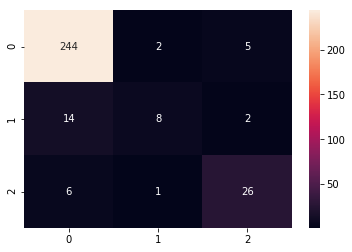

In [49]:
#confusion matrix
import pandas

csv_filepath = 'test.csv'
prediction_labels = pandas.read_csv(csv_filepath)
test_folder = '../../data_train/test_ser_labeled/'


prediction_labels_list = []
true_labels_list = []

for index in range(len(prediction_labels['file_path'])):
    file = prediction_labels['file_path'][index]
    prediction_label = prediction_labels['label'][index]
    prediction_labels_list.append(prediction_label)

    #need to check which file_path is in data_emotion_target_dictionary
    file_path = test_folder+file[:-4]+'_neutral.wav'
    if file_path in data_emotion_target_dictionary:
        true_label = data_emotion_target_dictionary[file_path]
    file_path = test_folder+file[:-4]+'_non-neutral-female.wav'
    if file_path in data_emotion_target_dictionary:
        true_label = data_emotion_target_dictionary[file_path]
    file_path = test_folder+file[:-4]+'_non-neutral-male.wav'
    if file_path in data_emotion_target_dictionary:
        true_label = data_emotion_target_dictionary[file_path]
    
    true_labels_list.append(true_label)
        
prediction_labels_list = np.array(prediction_labels_list)        
true_labels_list = np.array(true_labels_list)        
labels = ['neutral', 'non-neutral-male', 'non-neutral-female']

confusion_matrix = sklearn.metrics.confusion_matrix(true_labels_list, prediction_labels_list, labels)
print(confusion_matrix)
import seaborn as sns
f = sns.heatmap(confusion_matrix, annot=True, fmt='d')


{'../../data_train/train/bpubdl01_segment230_neutral.wav': 'neutral',
 '../../data_train/train/bpubcv09_segment485_neutral.wav': 'neutral',
 '../../data_train/train/bpubcv01_segment230_neutral.wav': 'neutral',
 '../../data_train/train/bpubdl10_segment79_neutral.wav': 'neutral',
 '../../data_train/train/bpubmn08_segment105_neutral.wav': 'neutral',
 '../../data_train/train/bfamcv09_segment394_neutral.wav': 'neutral',
 '../../data_train/train/bpubcv02_segment99_neutral.wav': 'neutral',
 '../../data_train/train/bfamdl09_segment182_neutral.wav': 'neutral',
 '../../data_train/train/bpubdl11_segment364_neutral.wav': 'neutral',
 '../../data_train/train/bfamdl31_segment707_non-neutral-male.wav': 'non-neutral-male',
 '../../data_train/train/bfammn22_segment162_neutral.wav': 'neutral',
 '../../data_train/train/bpubdl09_segment129_neutral.wav': 'neutral',
 '../../data_train/train/bfammn21_segment93_non-neutral-male.wav': 'non-neutral-male',
 '../../data_train/train/bfammn16_segment99_neutral.wav':